In [31]:
import numpy as np
import matplotlib.pyplot as plt

### Paths

In [32]:
import os

USER_PATH = os.getcwd()
SAVE_PATH = USER_PATH + "/plots/"

### Settings

In [33]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title

In [34]:
in_width      = 64
# Out width
frac_width    = 10
integer_width = int(np.floor(np.log2(in_width-1))+1)
out_width     = integer_width + frac_width
LUT_input = np.linspace(0,2**frac_width,2**frac_width,endpoint=False, dtype=np.int64)

## Look up table method

In [35]:
LUT_output = np.log2(1+LUT_input/(1<<frac_width))*((1<<frac_width))
LUT_output = LUT_output.round()
LUT_output = LUT_output.astype(np.int32)

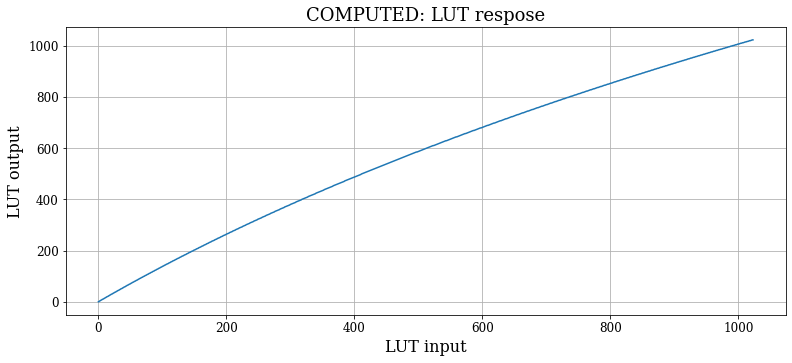

In [36]:
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(10,4))
# plt.axes(axisbelow=True)



#######################################################################
##### TOP PANEL
#######################################################################
fig.add_axes((0.,0.35,1.0,1.0))



plt.plot(LUT_input,LUT_output)
plt.title('COMPUTED: LUT respose')
plt.xlabel('LUT input')
plt.ylabel('LUT output')
plt.grid(True)

#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "LUT_response", bbox_inches='tight')
#######################################################################

plt.show()

In [45]:
N = 2**20

# Generate random input from 1 to (2**64)-1
Test_input    = np.random.randint(1,2**64-1,N, dtype=np.uint64)
#Test_input    = np.linspace(1,2**64-1,N,endpoint=False)
#Test_input    = np.floor(Test_input)
#Test_input    = Test_input.astype(np.uint64)

# Compute the exact logarithm
Exact_output  = np.log2(Test_input)

Test_input_ord   = np.sort(Test_input  , kind='heapsort')
Exact_output_ord = np.sort(Exact_output, kind='heapsort')


# Priority encoder output
prienc_out    = np.array(np.log2(Test_input), dtype=np.uint64)
# Extract the fractional part and convert in fixed point number
frac_in      = ((Test_input - 2**prienc_out)*2**(in_width-prienc_out))/(2**(in_width-frac_width))
frac_in      = frac_in.astype(np.uint64)
# Computed result
Comp_output   = ((prienc_out<<frac_width) + LUT_output[frac_in])/2**frac_width

# Evaluate the error
Error         = Exact_output - Comp_output

## Plots

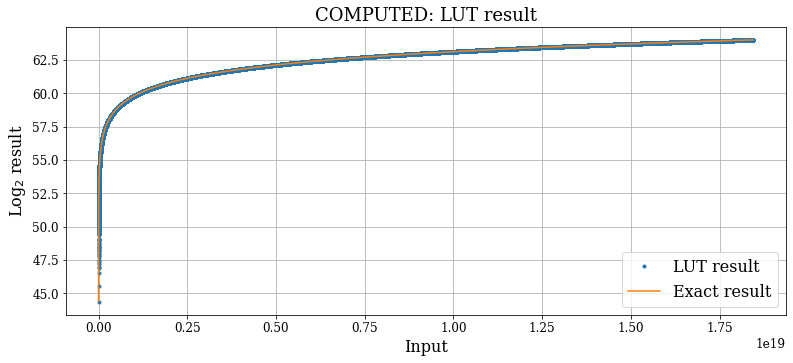

In [46]:
# Plot of input, computed result

#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(10,4))
# plt.axes(axisbelow=True)



#######################################################################
##### TOP PANEL
#######################################################################
fig.add_axes((0.,0.35,1.0,1.0))


plt.plot(Test_input    , Comp_output     , '.',label="LUT result  ")
plt.plot(Test_input_ord, Exact_output_ord,     label="Exact result")
plt.title('COMPUTED: LUT result')
plt.xlabel('Input')
plt.ylabel('Log$_2$ result')
plt.grid(True)
plt.legend()

#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "LUT_LOG_out", bbox_inches='tight')
#######################################################################

plt.show()

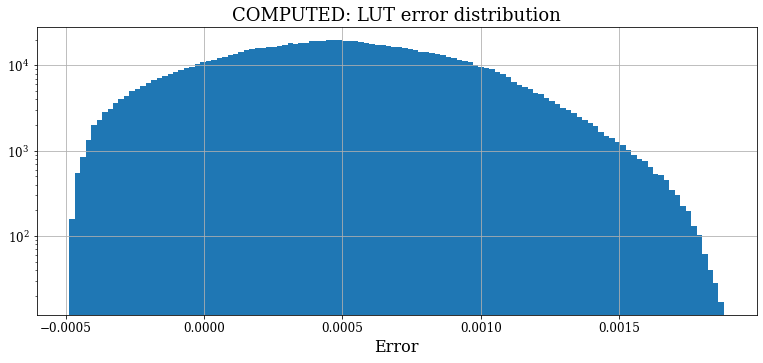

Mean error  0.000492
Standard deviation error  0.000412


In [47]:
# Error distribution
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(10,4))
# plt.axes(axisbelow=True)



#######################################################################
##### TOP PANEL
#######################################################################
fig.add_axes((0.,0.35,1.0,1.0))

plt.hist(Error,bins=120)
plt.title('COMPUTED: LUT error distribution')
plt.xlabel('Error')
plt.semilogy()
plt.grid(True)

#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "LUT_LOG_error", bbox_inches='tight')
#######################################################################

plt.show()

print("Mean error  %f"               % np.mean(Error))
print("Standard deviation error  %f" % np.std(Error ))

## Taylor expansion method

$PE_{out}     = MSB(input)  $  
$I_{order}    = \frac{input - 2^{PE_{out}}}{2^{PE_{out}}}$  
$II_{order}  = I_{order}^2  $  
$III_{order} = I_{order}^3  $  
$Log_2(input) = PE_{out} + \frac{I_{order}}{ln(2)} - \frac{II_{order}}{2ln(2)} + \frac{III_{order}}{3ln(2)}$



In [48]:
I_or   = LUT_input/(2**frac_width)
II_or  = I_or**2
III_or = I_or**3
IV_or = I_or**4

Exact_value = np.log2(1+I_or)
I_corr  = I_or/(np.log(2))
II_corr = I_corr-II_or/(2*np.log(2))
III_corr = II_corr+III_or/(3*np.log(2))
IV_corr  = III_corr-IV_or/(4*np.log(2))

TE_out = III_corr
TE_out_mean = (II_corr + III_corr)/2

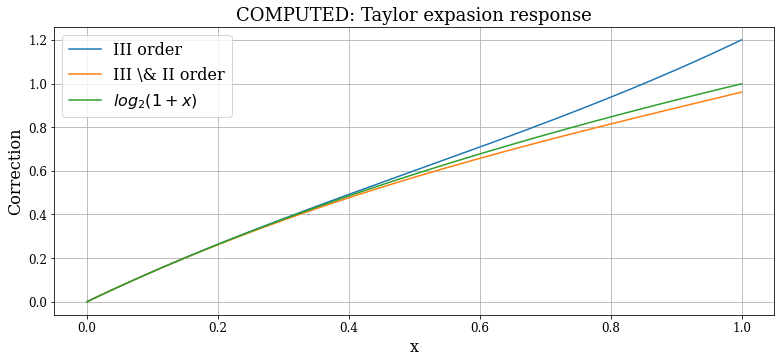

In [49]:
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(10,4))
# plt.axes(axisbelow=True)



#######################################################################
##### TOP PANEL
#######################################################################
fig.add_axes((0.,0.35,1.0,1.0))



plt.plot(I_or,TE_out,label="III order")
plt.plot(I_or,TE_out_mean, label="III \& II order")
#plt.plot(I_or,I_or, label="Mitchell approx")
plt.plot(I_or,Exact_value,label="$log_2(1+x)$")

plt.title('COMPUTED: Taylor expasion response')
plt.xlabel('x')
plt.ylabel('Correction')

plt.grid(True)
plt.legend()

#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "TE_respnse", bbox_inches='tight')
#######################################################################

plt.show()

In [50]:
I_order     = frac_in
II_order    = I_order**2/2**frac_width
II_order    = II_order.astype(np.uint32)
III_order   = I_order**3/(2**(2*frac_width))
III_order   = III_order.astype(np.uint32)

ln2_1          = int(1/np.log(2)*2**frac_width)
ln2_2          = int(1/np.log(2)*2**frac_width/2)
ln2_3          = int(1/np.log(2)*2**frac_width/3)

Corr = (I_order*ln2_1 - II_order*ln2_2 + III_order*ln2_3)/2**frac_width
Corr = Corr.astype(np.uint32)


Comp_output_te = prienc_out + (Corr)/2**frac_width

Error_te       = Exact_output - Comp_output_te

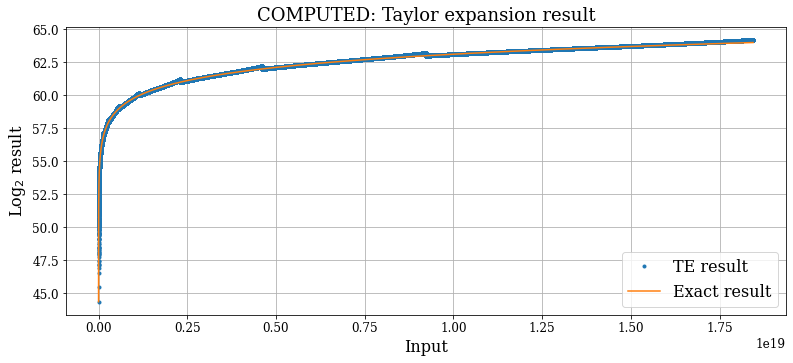

In [51]:
# Plot of input, computed result
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(10,4))
# plt.axes(axisbelow=True)



#######################################################################
##### TOP PANEL
#######################################################################
fig.add_axes((0.,0.35,1.0,1.0))


plt.plot(Test_input    , Comp_output_te  , '.',label="TE result  ")
plt.plot(Test_input_ord, Exact_output_ord,     label="Exact result")
plt.title('COMPUTED: Taylor expansion result')
plt.xlabel('Input')
plt.ylabel('Log$_2$ result')
plt.grid(True)
plt.legend()

#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "TE_LOG_out", bbox_inches='tight')
#######################################################################

plt.show()

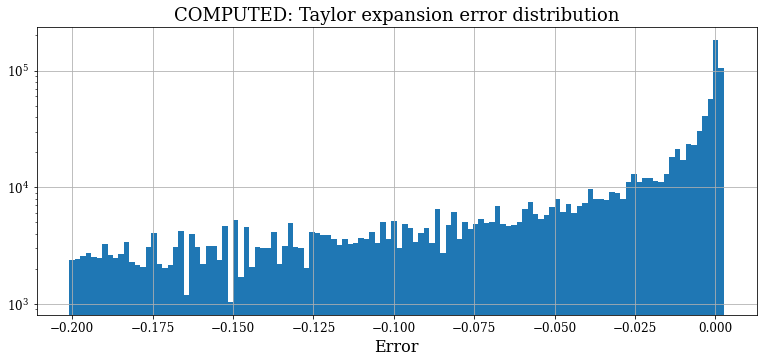

Mean error  -0.042922
Standard deviation error  0.055521


In [52]:
# Error distribution
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(10,4))
# plt.axes(axisbelow=True)



#######################################################################
##### TOP PANEL
#######################################################################
fig.add_axes((0.,0.35,1.0,1.0))


plt.hist(Error_te,bins=120)
plt.title('COMPUTED: Taylor expansion error distribution')
plt.xlabel('Error')
plt.semilogy()

plt.grid(True)

#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "TE_LOG_error", bbox_inches='tight')
#######################################################################

plt.show()
print("Mean error  %f"               % np.mean(Error_te))
print("Standard deviation error  %f" % np.std(Error_te ))